# Loading mean waveforms from a .dat file

_Author : Sofia Skromne Carrasco_

This tutorial shows how to extract the mean waveform of cells from the .dat file. Klusters/Phy and others usually have a waveform that is already generated for each neuron. The advantages of extracting the neuron from the .dat file instead are:

1) We can determine the window of the waveform we want to see, whereas we cannot edit the waveform window that has been generated by Klusters/Phy. 

2) We can restrict the calculation of the waveform to a specific epoch in the recording, such as when the animal is sleeping or while it is performing a task. It is also possible to ignore noisy sections of the recording.

3) We can customize how many channels we want to see when visualizing a particular waveform.

4) We can determine the number or proportion of spikes used to calculate the mean waveform




See the [documentation](https://peyrachelab.github.io/pynapple/#installation) of pynapple for instructions on installing the package.

The example data can be found [here](https://www.dropbox.com/s/1kc0ulz7yudd9ru/A2929-200711.tar.gz?dl=1).


In [1]:
import os,sys
import numpy as np
import pynapple as nap
import pandas as pd
from scipy.fft import fft
from xml.dom import minidom
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

data_directory = '/home/sofia/Pynacollada_notebooks/A2929-200711'

data = nap.load_session(data_directory, 'neurosuite')

----------

## TL;DR

Pynapple already has a built-in function to load the mean waveform from the .dat file. Using this function, we are able to restrict the mean waveform extraction to a specific window, epoch or spike count.


In [2]:
meanwf, maxch = data.load_mean_waveforms()


We can visualize the mean waveforms of all our neurons:

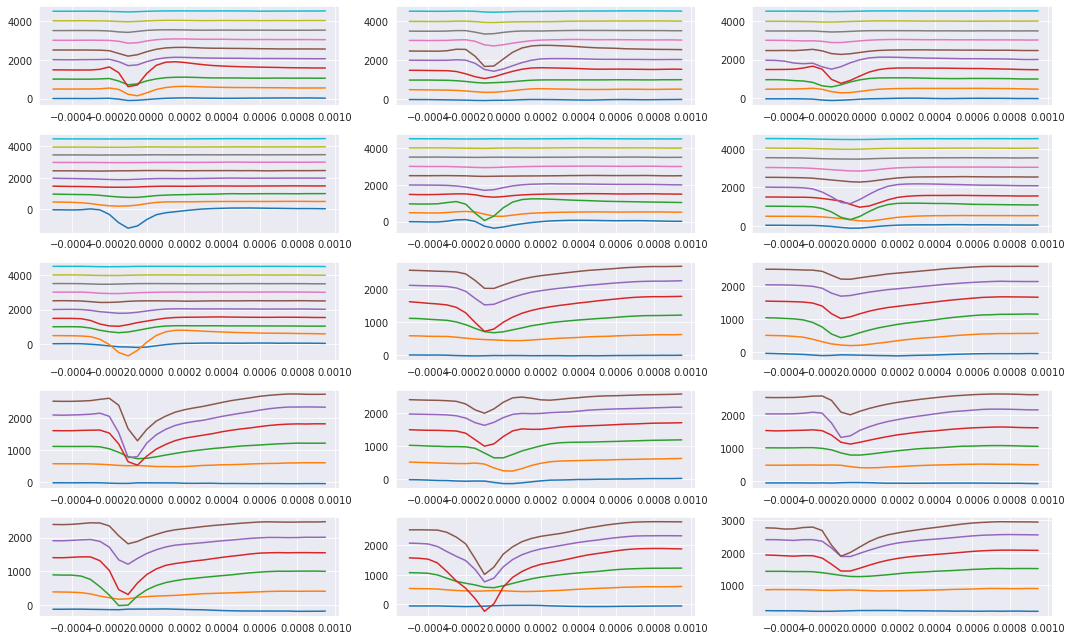

In [3]:
plt.figure(figsize = (15,9))
for i,neuron in enumerate(meanwf):
    plt.subplot(5,3,i+1)
    channel_offset = np.tile(np.array(meanwf[neuron].columns),
                            (len(meanwf[neuron].index),1))*500
    plt.plot(meanwf[neuron]+channel_offset)
plt.tight_layout()


We can also visualize only the channel where the waveform is most strongly detected:

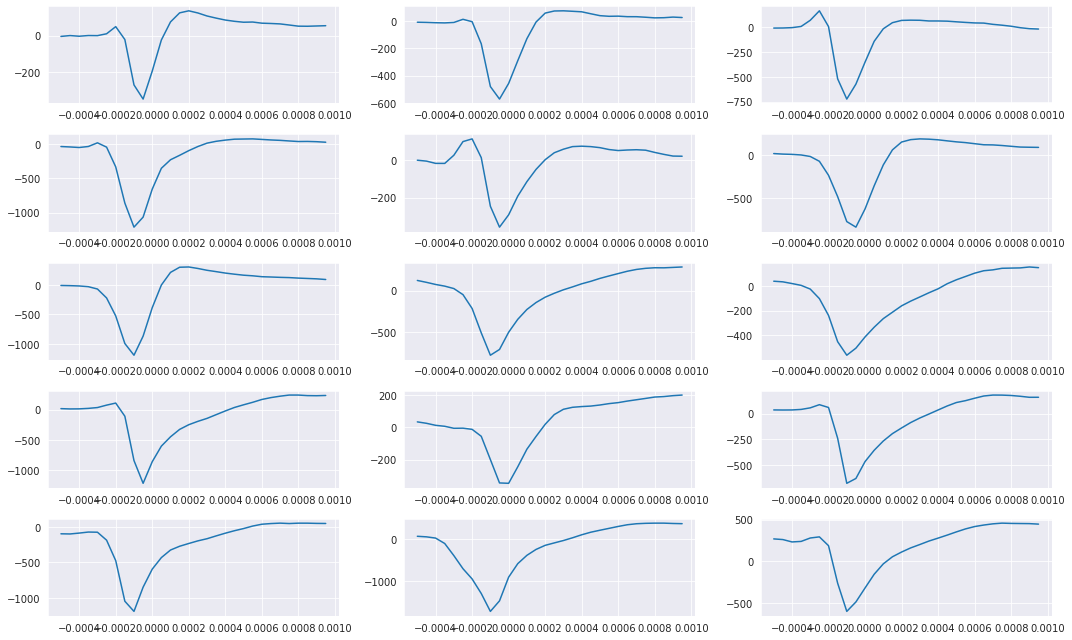

In [4]:
plt.figure(figsize = (15,9))
for i,neuron in enumerate(meanwf):
    plt.subplot(5,3,i+1)
    plt.plot(meanwf[neuron][maxch[neuron]])
plt.tight_layout()

*****

## Step-by-step tutorial

### Generating the mean waveforms

The first step is to load the xml file. This will give us information such as the number of channels we recorded from and how they are grouped together.

In [5]:
data.load_neurosuite_xml(data.path)
n_channels = data.nChannels #number of channels used to record
fs = data.fs_dat #sampling rate (samples per second)
group_to_channel = data.group_to_channel #how the channels were grouped together
group = data.spikes.get_info('group') #the channel group where each neuron was found

print('Number of channels used in the recording: ', n_channels)
print('Sampling rate: ', fs)
print('Groups of channels: ', group_to_channel)
print('Group of each neuron: \n', group)

Number of channels used in the recording:  16
Sampling rate:  20000
Groups of channels:  {0: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 1: array([10, 11, 12, 13, 14, 15])}
Group of each neuron: 
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
Name: group, dtype: int64



Now that we have our xml data, the next step is to find our .dat file and map it to memory. Dat files tend to be very big so we never save the entire file as a variable. Rather, we tell the computer to remember the location of the file and how to read it. 


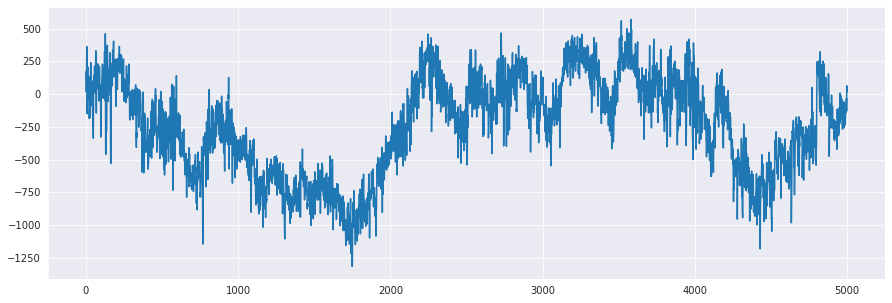

In [6]:
files = os.listdir(data_directory)
dat_files    = np.sort([f for f in files if 'dat' in f and f[0] != '.']) #find all dat files in directory

#In order to read the dat file, we need to know the number of samples collected in the recording
file = os.path.join(data_directory, dat_files[0])
f = open(file, 'rb') #open dat file in read binary mode
startoffile = f.seek(0, 0)
endoffile = f.seek(0, 2)
bytes_size = 2
n_samples = int((endoffile-startoffile)/n_channels/bytes_size) #This is the number of samples collected
f.close()     

#map to memory all samples for all channels. Channels are numbered according to neuroscope number
fp = np.memmap(file, np.int16, 'r', shape = (n_samples, n_channels))

#let's visualize a small window of the first channel
plt.figure(figsize = (15,5))
plt.plot(fp[22000:27000,0])


Note that now our dat file outputs voltage by sample number. Our spike times are in seconds. In order to get the waveforms of the neurons from the dat file, we need to convert seconds to sample number. We also need to decide how many samples we want to collect per spike to obtain the full waveform.


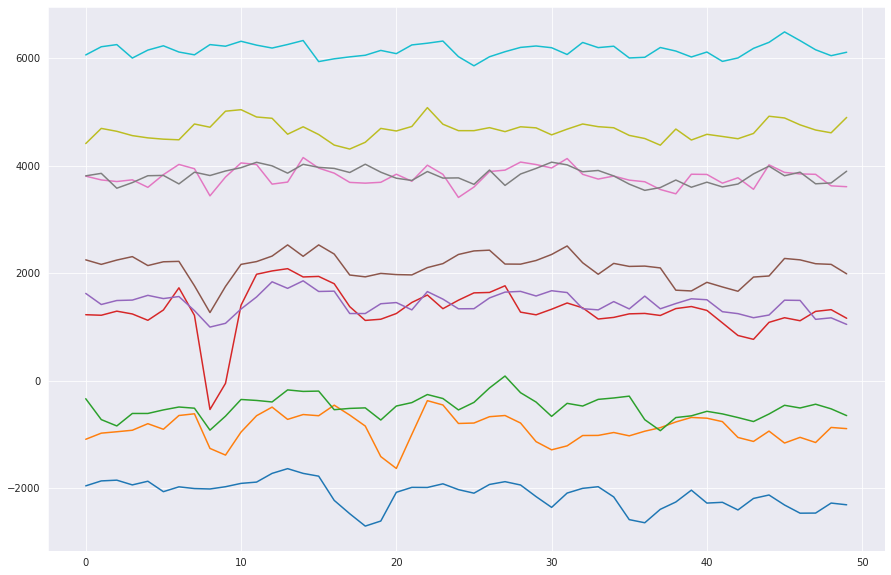

In [7]:
#convert spike times to spikes by sample number
spikes = data.spikes
sample_spikes = {neuron:(spikes[neuron].as_units('s').index.values*fs).astype('int') for neuron in spikes}

#waveform window in samples taken before and after the spike times
waveform_window = (np.array([0.0005, 0.002]) * fs).astype(int) #waveform window in seconds * sampling rate


#let's check this window with a random spike from one of the neurons
random_neuron = 0 #taking the first neuron
random_spike = sample_spikes[random_neuron][5] #fifth spike from the neuron picked
test_window = [random_spike - waveform_window[0],
              random_spike + waveform_window[1]]
test_shank = group_to_channel[group[random_neuron]] #need to know what channels we should expect the spike to be in

#Plot the waveform, offsetting each channel so that they do not overlap in the plot
plt.figure(figsize = (15,10))
channel_offset = np.tile(test_shank, (len(fp[test_window[0]:test_window[1]]),1))*800
plt.plot((fp[test_window[0]:test_window[1], test_shank])*2+channel_offset)


The window seems to work well for this neuron. It can always be made larger or smaller depending on what the spike looks like, and it also does not need to be symmetrical around the spike time. 

Now that we are happy with our window, let's prepare to parse through the dat file and find our mean waveforms. Some things to take into account: 
1) We will be loading the dat in small batches so as to not overload the computer's memory. It's important that the batches have some overlap so that if a spike is at the edge of two batches, it will still be detected in full.

2) We could take every single spike of every single neuron, but particularly for very long recordings or neurons that have very high firing rates, this becomes very inefficient. Rather than taking every single spike, we can take a subset of them to compute our mean waveform. The higher the number, the more accurate the mean waveform will be but the longer it will take to compute so it's important to find the right balance.


In [8]:
overlap = sum(waveform_window) #Overlap of dat batches will be the duration of one waveform
batch_size = 3000000 #Number of samples that will be loaded at one time. This number can be adjusted based on computing power

#Let's determine the sample numbers of each of our batches
batch_windows = np.arange(0, int(endoffile/n_channels/bytes_size), batch_size)
batches = []
for i in batch_windows: #Make overlapping batches from the beginning to the end of the recording
    if i == batch_windows[-1]: #The last batch cannot overlap with the next one
        batches.append([i, n_samples])
    else:
        batches.append([i, i+batch_size+overlap])

print(batches)#let's make sure the dat batches overlap and that everything looks ok

[[0, 3000050], [3000000, 6000050], [6000000, 9000050], [9000000, 12000050], [12000000, 15000050], [15000000, 18000050], [18000000, 21000050], [21000000, 23999920]]



Now let's decide what and how many spikes we are taking from each of our neurons. Remember that we need to take the spikes in sample number, not in seconds


In [9]:
#Taking a subset of spikes for each neuron
spike_count = 1000 #Compute the mean waveform using 1000 spikes from each neuron

counted_spikes = {} #Take random spikes from each neuron throughout the recording
for index, neuron in enumerate(sample_spikes):
    if len(sample_spikes[neuron]) >= spike_count:
        counted_spikes[neuron] = np.array(np.random.choice(list(sample_spikes[neuron]), spike_count))
    elif len(sample_spikes[neuron]) < spike_count: #Take all spikes from the neuron if total spikes < spike_count
        print('Not enough spikes in neuron ' + str(index) + '... using all spikes')
        counted_spikes[neuron] = sample_spikes[neuron]

We are now ready to parse through the dat file. Note that depending on the length of the recording and the number of channels used to record, finding the spikes can take a while to run. Make sure you are happy with your parameters before parsing the dat file!

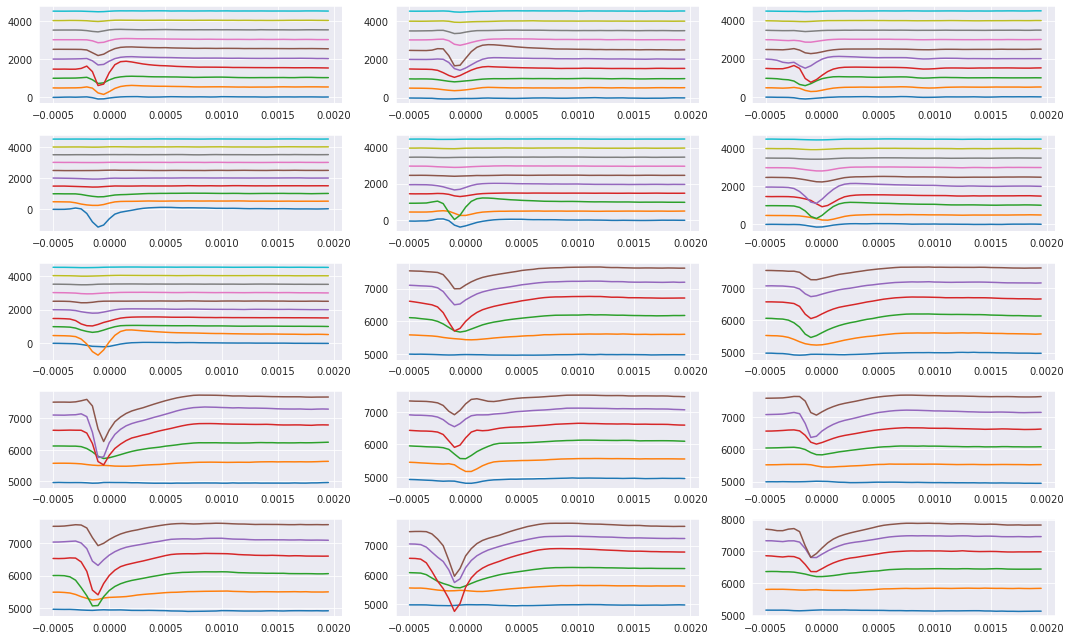

In [10]:
#Concatenate all spike times of all neurons - will be used to check for spikes before loading the dat
spike_check = np.array([int(spikes_neuron) 
                        for spikes_neuron in counted_spikes[neuron] 
                        for neuron in counted_spikes])

#Initialize the variable where the mean waveforms will be stored
neuron_waveforms = {n: np.zeros([np.sum(waveform_window), len(group_to_channel[group[n]])]) for n in sample_spikes}

for index, timestep in enumerate(batches):
    print(f'Extracting waveforms from dat file: window {index+1} / {len(batch_windows)}', end = '\r')

    if len(spike_check[(timestep[0]<spike_check) & (timestep[1]>spike_check)]) == 0:
        continue #if there are no spikes for any neurons in this batch, skip and go to the next one

    #Load dat file for timestep
    tmp = pd.DataFrame(data = fp[timestep[0]:timestep[1],:], 
                       columns = np.arange(n_channels), 
                       index = range(timestep[0],timestep[1])) 

    #Check for spikes neuron by neuron
    for neuron in counted_spikes:
        neurontmp = counted_spikes[neuron]
        tmp2 = neurontmp[(timestep[0]<neurontmp) & (timestep[1]>neurontmp)] #spikes present in this batch
        
        if len(neurontmp) == 0:
            continue #skip neuron if it has no spikes in this batch
        
        #Restrict dat file to the channel group of the neuron
        tmpn = tmp[group_to_channel[group[neuron]]]

        for time in tmp2: #add each spike waveform to neuron_waveform
            spikewindow = tmpn.loc[time-waveform_window[0]:time+waveform_window[1]-1] #waveform for this spike time
            try:
                neuron_waveforms[neuron] += spikewindow.values
            except: #ignore if full waveform is not present in this batch
                pass

            
#Convert our waveforms to a nicer format. We will also replace sample number back into seconds
meanwf = {n: pd.DataFrame(data = np.array(neuron_waveforms[n])/spike_count,
                                  columns = np.arange(len(group_to_channel[group[n]])),
                                  index = np.array(np.arange(-waveform_window[0], waveform_window[1]))/fs) for n in counted_spikes}




#Let's visualize the mean waveforms of the neurons
plt.figure(figsize = (15,9))
for i,neuron in enumerate(meanwf):
    plt.subplot(5,3,i+1)
    channel_offset = np.tile(group_to_channel[group[neuron]],
                            (len(meanwf[neuron].index),1))*500
    plt.plot(meanwf[neuron]+channel_offset)
plt.tight_layout()

One more thing we want to do is find the channel where the waveform is at its maximum. We can use this channel to compute our waveform features for waveform classification.

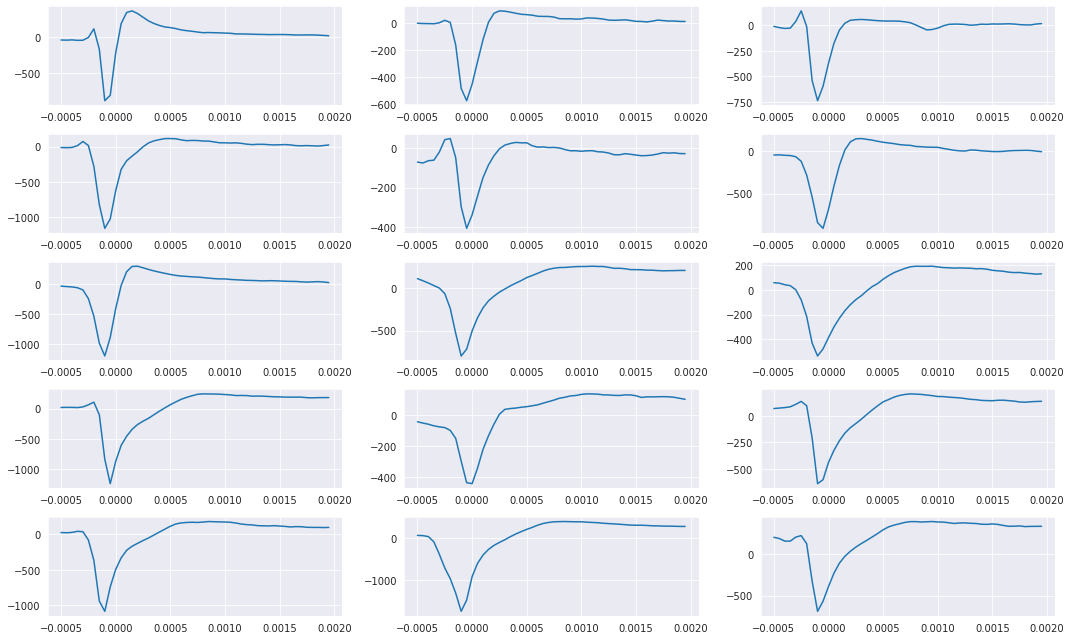

In [12]:
maxch = pd.Series(data = [meanwf[n][meanwf[n].loc[0].idxmin()].name for n in meanwf], 
                  index = spikes.keys())

maxwf = {neuron: meanwf[neuron][maxch[neuron]] for neuron in meanwf}

#Let's visualize the mean waveforms of the neurons
plt.figure(figsize = (15,9))
for i,neuron in enumerate(maxwf):
    plt.subplot(5,3,i+1)
    plt.plot(maxwf[neuron])
plt.tight_layout()

Once we are happy with our waveforms, the last step is to save them so we do not have to recompute them every single time. Waveforms can be saved in the NWB, but once saved in this format they cannot be modified. So, until you are 100% sure that you will not be adjusting your waveform parameters, you can save the mean waveforms as follows:

In [13]:
import pickle

waveform_info = [meanwf, maxch]

with open(os.path.join(data_directory, 'mean_waveforms.pickle'), 'wb') as handle:
    pickle.dump(waveform_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

The pickle file can be loaded by running these lines:

In [14]:
with open(os.path.join(data_directory, 'mean_waveforms.pickle'), 'rb') as handle:
    meanwf, maxch = pickle.load(handle)